# COGS 118B Project

### By Miguel Garcia and Janina Schuhmacher


In [1]:
import sklearn.metrics as metrics
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import check_X_y
import warnings
warnings.filterwarnings("ignore")

#name the columns
colnames=['age', 'workclass',  'fnlwgt', 'education', 
          'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'capital-gain', 
          'capital-loss', 'hours-per-week', 'native-country', 'income']

# read data in df
df = pd.read_csv('adult.data', names=colnames, header=None)


In [2]:
# display df header
data_top = df.head()   
data_top

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Drop null values

In [3]:
df.shape #before dropping nulls

(32561, 15)

In [4]:
for i in colnames:   #ignores all null values
    df = df[(df[i] != ' ?')]

In [5]:
df.shape #after dropping nulls

(30162, 15)

### Keep income only from Americans since it represents most of the data and remove trailing white space

In [6]:
df = df[(df['native-country'] == ' United-States')]
df = df.reset_index()

In [7]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

### Visualize the distribution of each feature

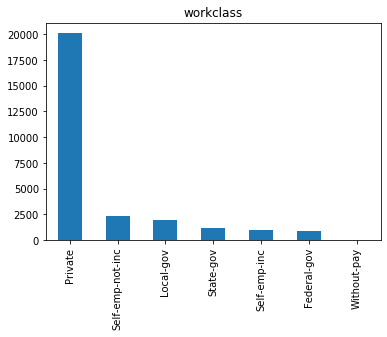

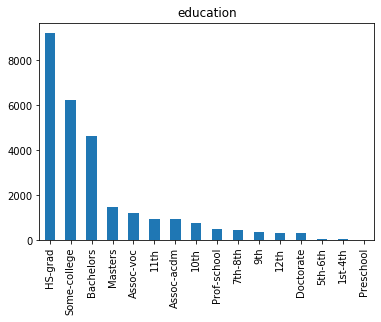

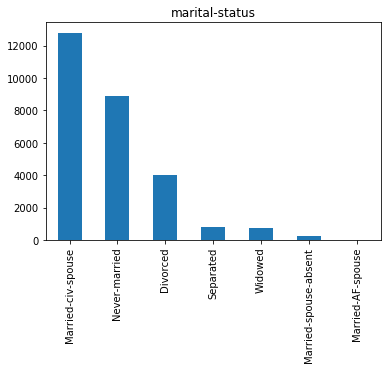

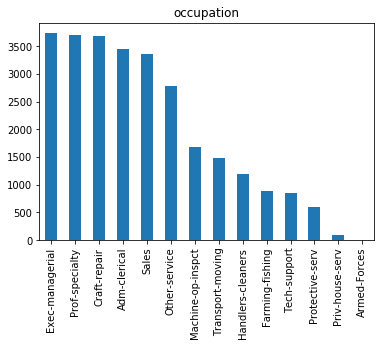

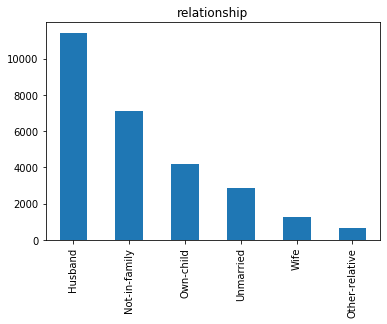

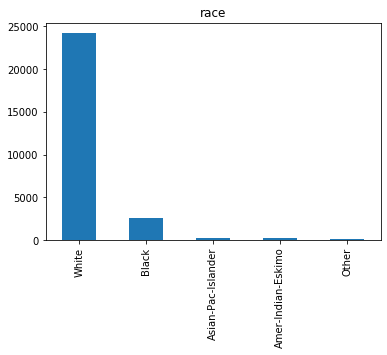

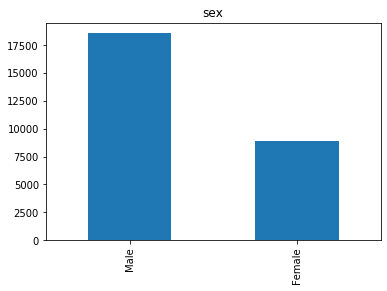

In [8]:
# plotting the frequency of the values

string_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

for col in string_columns: 
    fig, ax = plt.subplots()
    df[col].value_counts().plot(ax=ax, kind='bar', title = col)

### One hot encode

In [9]:
new_df = df[['age','fnlwgt','education-num','capital-gain',
             'capital-loss','hours-per-week']]  #non-categorical features (some are not important)
one_hot_cols = ['workclass', 'marital-status',
                'occupation','relationship','race']  #categorical features we care about
for i in one_hot_cols:  #for every categorical feature, onehot encode it
    new_df = new_df.join(pd.get_dummies(df[i],prefix = i))
    
new_df['income'] = pd.DataFrame((df['income'] == '>50K').astype(int))  #if greater than 50k 1 else 0 for label

In [10]:
for i in new_df.columns: #print new columns
    print(i)

age
fnlwgt
education-num
capital-gain
capital-loss
hours-per-week
workclass_Federal-gov
workclass_Local-gov
workclass_Private
workclass_Self-emp-inc
workclass_Self-emp-not-inc
workclass_State-gov
workclass_Without-pay
marital-status_Divorced
marital-status_Married-AF-spouse
marital-status_Married-civ-spouse
marital-status_Married-spouse-absent
marital-status_Never-married
marital-status_Separated
marital-status_Widowed
occupation_Adm-clerical
occupation_Armed-Forces
occupation_Craft-repair
occupation_Exec-managerial
occupation_Farming-fishing
occupation_Handlers-cleaners
occupation_Machine-op-inspct
occupation_Other-service
occupation_Priv-house-serv
occupation_Prof-specialty
occupation_Protective-serv
occupation_Sales
occupation_Tech-support
occupation_Transport-moving
relationship_Husband
relationship_Not-in-family
relationship_Other-relative
relationship_Own-child
relationship_Unmarried
relationship_Wife
race_Amer-Indian-Eskimo
race_Asian-Pac-Islander
race_Black
race_Other
race_Whit

In [11]:
new_df.head(10)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,37,284582,14,0,0,40,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
5,52,209642,9,0,0,45,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,31,45781,14,14084,0,50,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
7,42,159449,13,5178,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
8,37,280464,10,0,0,80,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
9,23,122272,13,0,0,30,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


In [12]:
new_df.shape   #shape after all cleaning

(27504, 46)

In [13]:
new_df = new_df.reset_index()

In [14]:
new_df.columns[1:46]

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'rela

### Get indexes for each individual feature and their respective names

In [15]:
ranges = [[1,2],[3,4],[4,5],[5,6],[6,7],[7,14],[14,21],[21,35],[35,41],[41,46],[1,46]]
columns = ['Age', 'Education','Capital Gain','Capital Loss','Hours Per Week',
           'Workclass','Marital Status','Occupation','Relationship','Race' ,'All Columns']

### Permutate/Shuffle the dataframe before applying algorithms

In [16]:
new_df = new_df.reindex(np.random.permutation(new_df.index))
new_df.head(10)

,index,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
6307,6307,33,170769,16,99999,0,60,0,0,1,...,0,0,0,0,0,0,0,0,1,1
1631,1631,45,188386,9,0,1628,45,0,0,1,...,0,0,0,0,0,0,0,0,1,0
20147,20147,35,115618,9,0,0,50,0,0,0,...,0,0,0,0,0,0,0,0,1,1
10909,10909,64,170421,10,0,0,8,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17666,17666,55,342121,10,0,0,40,0,0,1,...,0,0,0,0,0,0,0,0,1,0
22735,22735,34,167832,6,0,0,40,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1888,1888,60,207665,9,0,0,40,0,0,1,...,0,0,0,1,0,0,0,0,1,1
10639,10639,30,347166,9,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,1,0
18728,18728,57,170287,14,0,0,40,0,0,1,...,0,0,0,0,0,0,0,0,1,1
24462,24462,36,119957,13,0,0,35,0,0,1,...,0,0,1,0,0,0,1,0,0,0


### Function to return results for each classifier

In [17]:
def return_results(clf,string,is_svm,is_dummy,i):
    print('---------- Results Summary for',string,'for the column:',columns[i],'----------')
    print()
    X = sc.fit_transform(new_df.iloc[:,ranges[i][0]:ranges[i][1]])  #apply standard scaler
    
    X_train = X[:num_training]   #training features 80% of data
    X_test = X[num_training:]    #testing features 20% of data
    Y_train = Y[:num_training]   #training labels 80% of data
    Y_test = Y[num_training:]   #testing labels 20% of data
    start_time = time.time()  #start counting time
    clf.fit(X_train, Y_train) #train algorithm
    scores = 0
    if is_svm == True:  #if it is an svm we do cross validation
        scores = cross_val_score(clf, X_test, Y_test, cv=5)  #5 cross validation folds for accuracy
        scores = max(scores)
    elif is_dummy == True:   #if it is dummy we calculate accuracy differently
        X_trainc, Y_trainc = \
                         check_X_y(X=X_train, y=Y_train)
        X_testc, Y_testc = \
                         check_X_y(X=X_test, y=Y_test)
        clf.fit(X=X_trainc, y=Y_trainc)
        clf.score(X_testc,Y_testc)
                
    else:
        scores = clf.score(X_test,Y_test) #otherwise use default function
        
    print(str(time.time() - start_time)+" seconds for ", string, " to train") #end time counting and print
    print('Using' ,columns[i],'as a predictor for ' ,string,
          ' we get train accuracy of: ',clf.score(X_train,Y_train))  # train accuracy
    print('Using' ,columns[i],'as a predictor for ' ,string,
          ' we get test accuracy of: ',scores)  # calculate accuracy using 20%
    print()
    
    #confusion matrix
    cf_matrix = pd.DataFrame(confusion_matrix(Y_test, clf.predict(X_test)),index = ["True <50k", "True >50k"],
                columns = ["Pred <50k", "Pred >50k"])
    print('Confusion Matrix: ')
    print(cf_matrix)
    print()
    
    #f1 score
    score_f1 = f1_score(Y_test, clf.predict(X_test))
    print('F1-score is:',score_f1)

    #plot ROC
    fpr, tpr, thr = metrics.roc_curve(Y_test, clf.predict(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic Curve for ' + str(string))
    plt.plot(fpr, tpr)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print()

### Classifiers we will use with different initializations

In [18]:
#classifiers we will use with different initializations
classifiers = [GaussianNB()]
classifiers.append(SVC(kernel = 'linear',gamma ='auto',random_state = 50))
classifiers.append(SVC(kernel = 'sigmoid',gamma ='auto',random_state = 50))
classifiers.append(SVC(kernel = 'rbf',gamma ='auto',random_state = 50)) #radial basis function kernel
classifiers.append(MLPClassifier(solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(MLPClassifier(activation = 'logistic',solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(MLPClassifier(activation = 'tanh',solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(DummyClassifier(strategy="most_frequent")) #“most_frequent”: always predicts the most frequent label in the training set.
classifiers.append(DummyClassifier(strategy="stratified")) #“stratified”: generates predictions by respecting the training set’s class distribution.
classifiers.append(DummyClassifier(strategy="prior"))#“prior”: always predicts the class that maximizes the class prior (like “most_frequent”) and predict_proba returns the class prior.

### Name of the Classifiers

In [19]:
names = ['GaussianNB','SVM with Linear Kernel','SVM with Sigmoid Kernel','SVM with Radial Basis Function Kernel',
        'Neural Network with ReLU activation','Neural Network with Logistic Sigmoid activation',
        'Neural Network with tanh activation', 'Dummy Classifier that predicts most frequent',
        'Dummy Classifier that makes stratified predictions',
        'Dummy Classifier that maximizes the prior']

### Calculate accuracy per each feature

--------------- Returning Algorithm Results Summary for the feature: Age ---------------

---------- Results Summary for GaussianNB for the column: Age ----------

0.0039958953857421875 seconds for  GaussianNB  to train
Using Age as a predictor for  GaussianNB  we get train accuracy of:  0.743989455983275
Using Age as a predictor for  GaussianNB  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


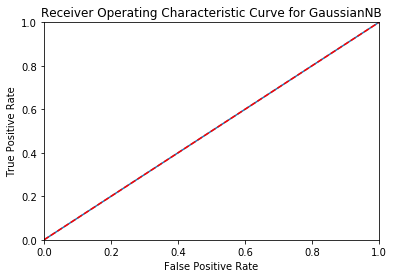


---------- Results Summary for SVM with Linear Kernel for the column: Age ----------

6.4458229541778564 seconds for  SVM with Linear Kernel  to train
Using Age as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.743989455983275
Using Age as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


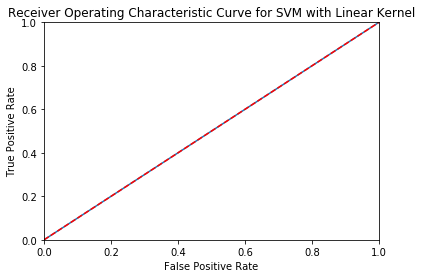


---------- Results Summary for SVM with Sigmoid Kernel for the column: Age ----------

10.092379808425903 seconds for  SVM with Sigmoid Kernel  to train
Using Age as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.677453074580739
Using Age as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.6724294813466788

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3339        800
True >50k        944        418

F1-score is: 0.324031007751938


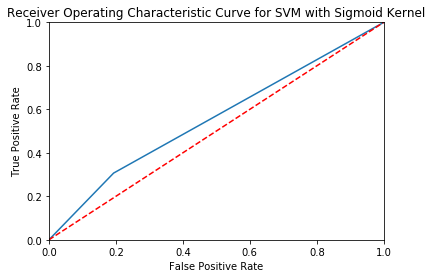


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Age ----------

5.8830530643463135 seconds for  SVM with Radial Basis Function Kernel  to train
Using Age as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.743989455983275
Using Age as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


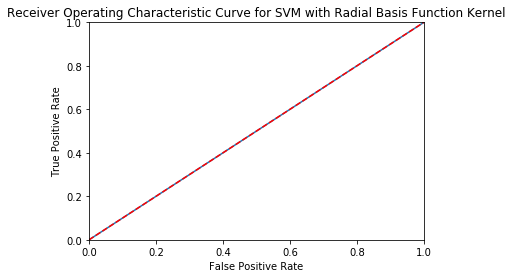


---------- Results Summary for Neural Network with ReLU activation for the column: Age ----------

0.23706889152526855 seconds for  Neural Network with ReLU activation  to train
Using Age as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7293550879425533
Using Age as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7400472641337938

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4047         92
True >50k       1338         24

F1-score is: 0.03247631935047361


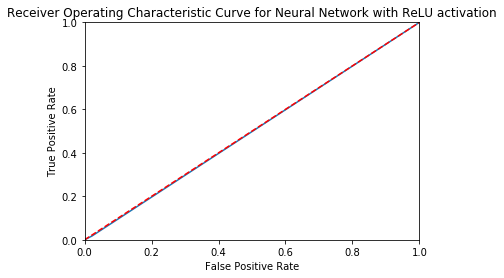


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Age ----------

0.44669413566589355 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.743989455983275
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


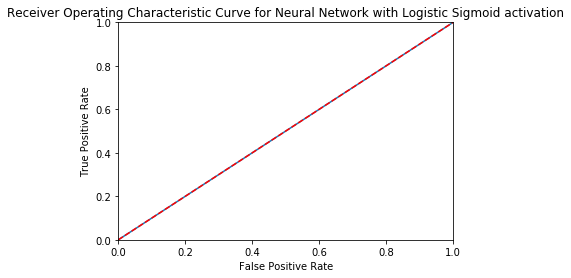


---------- Results Summary for Neural Network with tanh activation for the column: Age ----------

0.4508388042449951 seconds for  Neural Network with tanh activation  to train
Using Age as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.743989455983275
Using Age as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


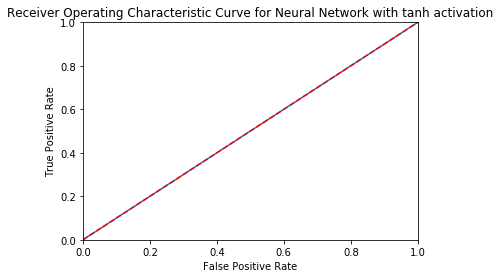


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Age ----------

0.01027679443359375 seconds for  Dummy Classifier that predicts most frequent  to train
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.743989455983275
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


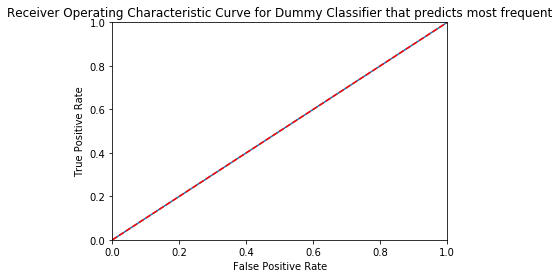


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Age ----------

0.004328012466430664 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Age as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6161432531927464
Using Age as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3101       1038
True >50k       1003        359

F1-score is: 0.24838012958963285


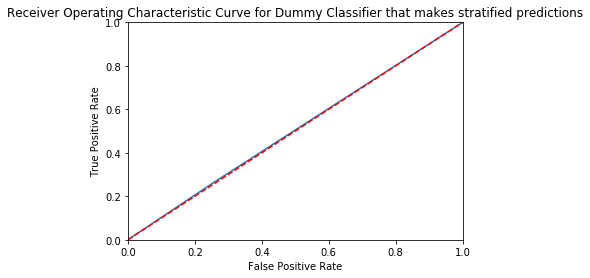


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Age ----------

0.0019502639770507812 seconds for  Dummy Classifier that maximizes the prior  to train
Using Age as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.743989455983275
Using Age as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


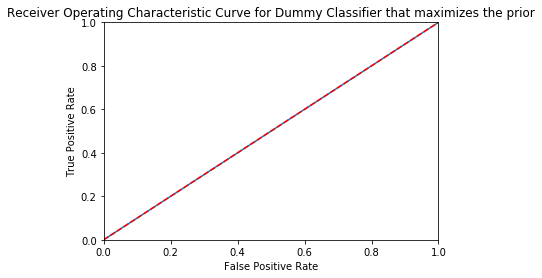


--------------- Returning Algorithm Results Summary for the feature: Education ---------------

---------- Results Summary for GaussianNB for the column: Education ----------

0.002192974090576172 seconds for  GaussianNB  to train
Using Education as a predictor for  GaussianNB  we get train accuracy of:  0.7673953551788393
Using Education as a predictor for  GaussianNB  we get test accuracy of:  0.772223232139611

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3967        172
True >50k       1081        281

F1-score is: 0.3096418732782369


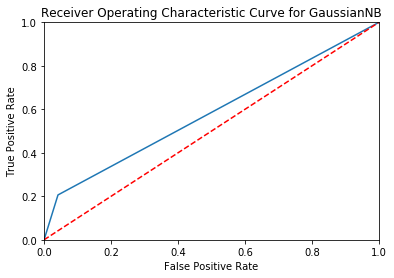


---------- Results Summary for SVM with Linear Kernel for the column: Education ----------

4.870965003967285 seconds for  SVM with Linear Kernel  to train
Using Education as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.743989455983275
Using Education as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


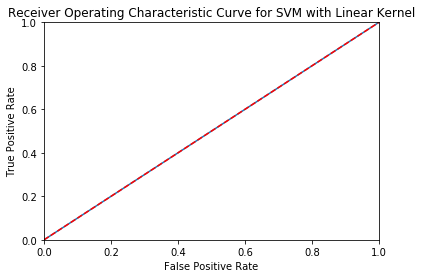


---------- Results Summary for SVM with Sigmoid Kernel for the column: Education ----------

8.505219221115112 seconds for  SVM with Sigmoid Kernel  to train
Using Education as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.6304594827978003
Using Education as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.6730245231607629

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2974       1165
True >50k        858        504

F1-score is: 0.3325635103926097


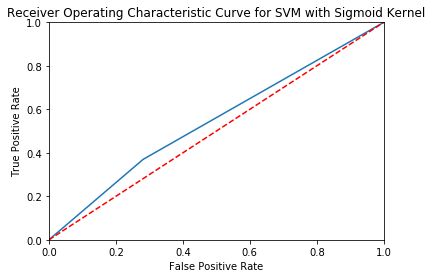


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Education ----------

7.040761232376099 seconds for  SVM with Radial Basis Function Kernel  to train
Using Education as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7673953551788393
Using Education as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7763636363636364

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3967        172
True >50k       1081        281

F1-score is: 0.3096418732782369


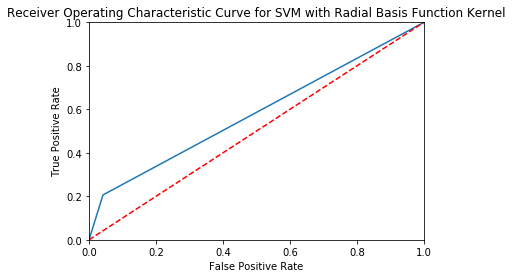


---------- Results Summary for Neural Network with ReLU activation for the column: Education ----------

0.2846510410308838 seconds for  Neural Network with ReLU activation  to train
Using Education as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7673953551788393
Using Education as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.772223232139611

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3967        172
True >50k       1081        281

F1-score is: 0.3096418732782369


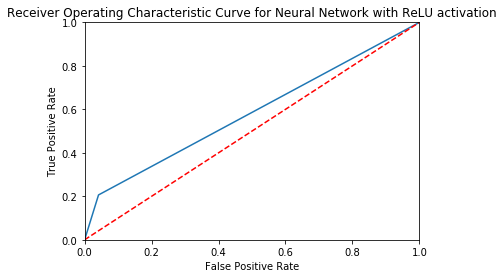


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Education ----------

0.2617638111114502 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7673953551788393
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.772223232139611

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3967        172
True >50k       1081        281

F1-score is: 0.3096418732782369


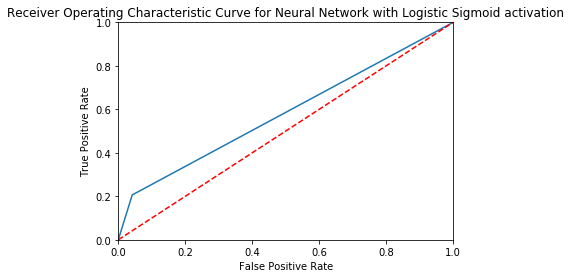


---------- Results Summary for Neural Network with tanh activation for the column: Education ----------

0.25689077377319336 seconds for  Neural Network with tanh activation  to train
Using Education as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7673953551788393
Using Education as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.772223232139611

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3967        172
True >50k       1081        281

F1-score is: 0.3096418732782369


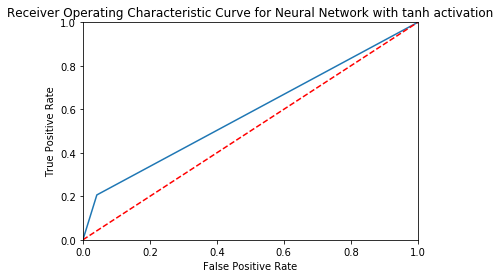


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Education ----------

0.006201028823852539 seconds for  Dummy Classifier that predicts most frequent  to train
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.743989455983275
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


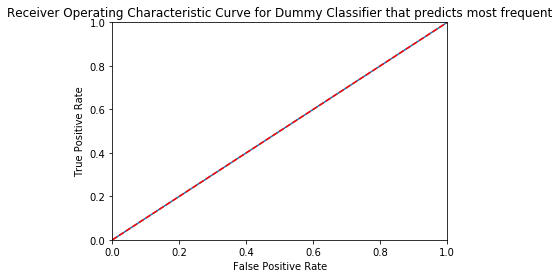


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Education ----------

0.0019571781158447266 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Education as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6225060219061037
Using Education as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3104       1035
True >50k       1034        328

F1-score is: 0.25234996384671005


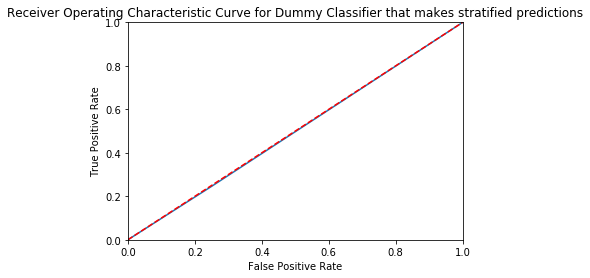


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Education ----------

0.005714893341064453 seconds for  Dummy Classifier that maximizes the prior  to train
Using Education as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.743989455983275
Using Education as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


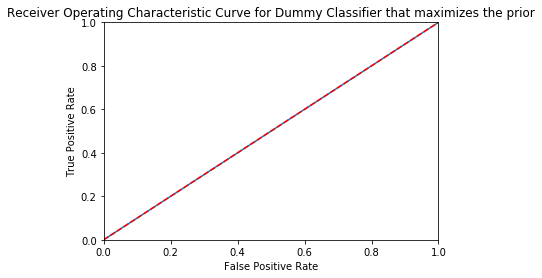


--------------- Returning Algorithm Results Summary for the feature: Capital Gain ---------------

---------- Results Summary for GaussianNB for the column: Capital Gain ----------

0.005461215972900391 seconds for  GaussianNB  to train
Using Capital Gain as a predictor for  GaussianNB  we get train accuracy of:  0.77898468390674
Using Capital Gain as a predictor for  GaussianNB  we get test accuracy of:  0.7836756953281222

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4021        118
True >50k       1072        290

F1-score is: 0.327683615819209


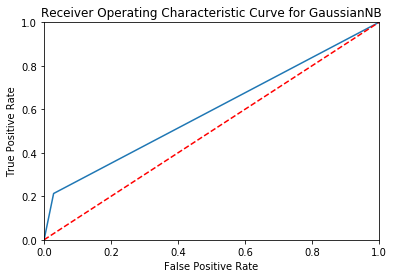


---------- Results Summary for SVM with Linear Kernel for the column: Capital Gain ----------

2.3793609142303467 seconds for  SVM with Linear Kernel  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7841203472253784
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7961783439490446

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4071         68
True >50k       1087        275

F1-score is: 0.3225806451612903


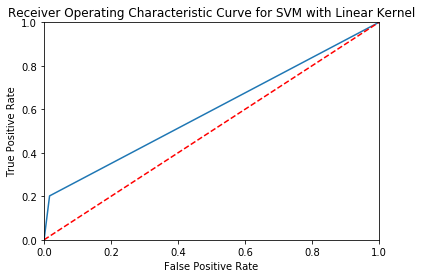


---------- Results Summary for SVM with Sigmoid Kernel for the column: Capital Gain ----------

4.610889911651611 seconds for  SVM with Sigmoid Kernel  to train
Using Capital Gain as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7591692041994273
Using Capital Gain as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7756584922797457

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3972        167
True >50k       1102        260

F1-score is: 0.2906651760760201


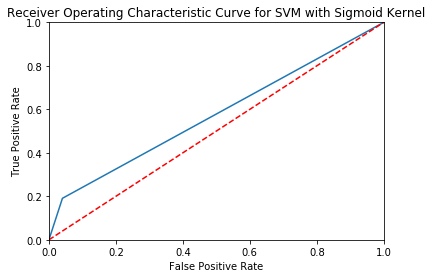


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Capital Gain ----------

2.9900059700012207 seconds for  SVM with Radial Basis Function Kernel  to train
Using Capital Gain as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7872108348861518
Using Capital Gain as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.8063636363636364

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4130          9
True >50k       1118        244

F1-score is: 0.30216718266253867


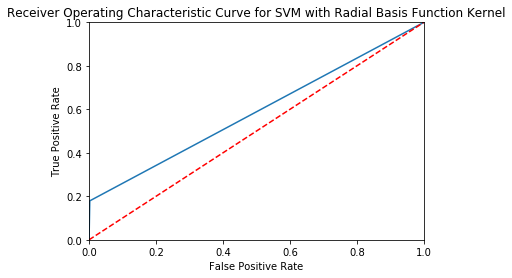


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Gain ----------

0.4100470542907715 seconds for  Neural Network with ReLU activation  to train
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7870290414943417
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7953099436466097

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4112         27
True >50k       1099        263

F1-score is: 0.3184019370460049


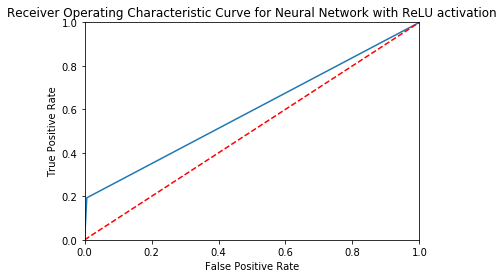


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Gain ----------

0.22359871864318848 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7876198700177248
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7958552990365388

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4115         24
True >50k       1099        263

F1-score is: 0.31898120072771374


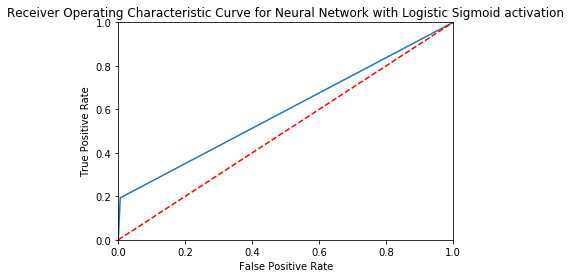


---------- Results Summary for Neural Network with tanh activation for the column: Capital Gain ----------

0.15474295616149902 seconds for  Neural Network with tanh activation  to train
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7866200063627687
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7947645882566806

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4127         12
True >50k       1117        245

F1-score is: 0.3026559604694256


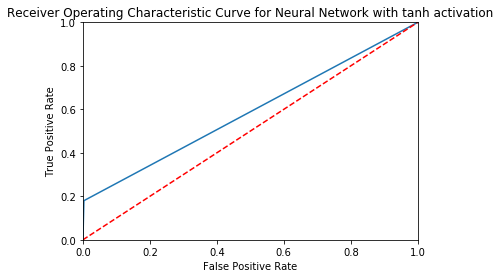


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Gain ----------

0.0018401145935058594 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.743989455983275
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


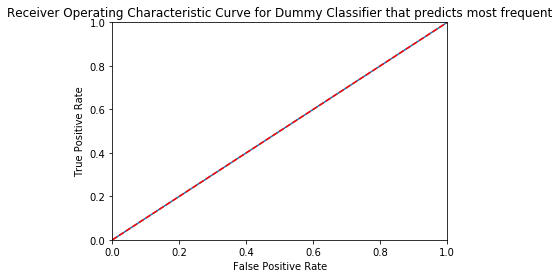


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Capital Gain ----------

0.002079010009765625 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Capital Gain as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6169613234558924
Using Capital Gain as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3049       1090
True >50k       1032        330

F1-score is: 0.2486447415973979


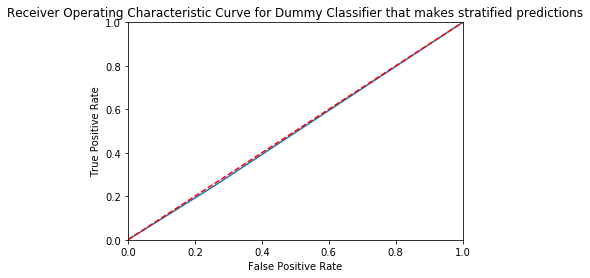


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Capital Gain ----------

0.0027587413787841797 seconds for  Dummy Classifier that maximizes the prior  to train
Using Capital Gain as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.743989455983275
Using Capital Gain as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


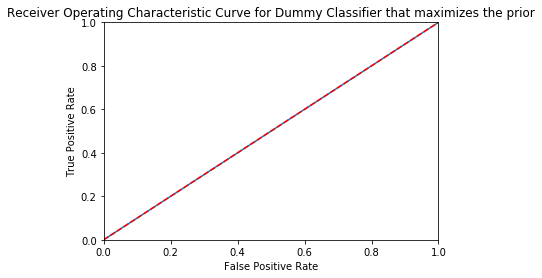


--------------- Returning Algorithm Results Summary for the feature: Capital Loss ---------------

---------- Results Summary for GaussianNB for the column: Capital Loss ----------

0.0032181739807128906 seconds for  GaussianNB  to train
Using Capital Loss as a predictor for  GaussianNB  we get train accuracy of:  0.7472162886879062
Using Capital Loss as a predictor for  GaussianNB  we get test accuracy of:  0.7516815124522814

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3997        142
True >50k       1224        138

F1-score is: 0.16808769792935443


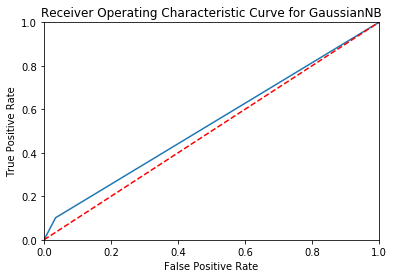


---------- Results Summary for SVM with Linear Kernel for the column: Capital Loss ----------

2.2393441200256348 seconds for  SVM with Linear Kernel  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7477162205153842
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7611262488646685

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4001        138
True >50k       1224        138

F1-score is: 0.16849816849816848


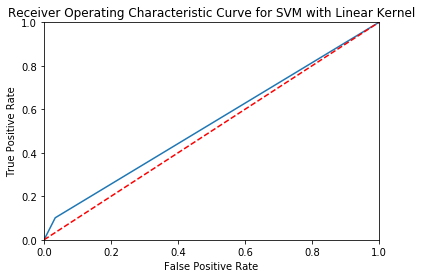


---------- Results Summary for SVM with Sigmoid Kernel for the column: Capital Loss ----------

4.514731168746948 seconds for  SVM with Sigmoid Kernel  to train
Using Capital Loss as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7449893196382311
Using Capital Loss as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4003        136
True >50k       1248        114

F1-score is: 0.14143920595533496


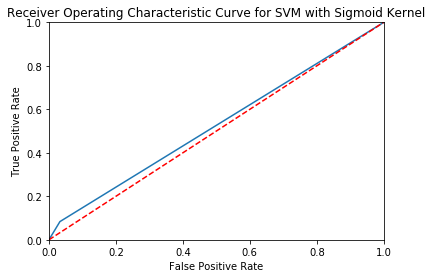


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Capital Loss ----------

3.340433120727539 seconds for  SVM with Radial Basis Function Kernel  to train
Using Capital Loss as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7598509294187157
Using Capital Loss as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7718181818181818

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4096         43
True >50k       1240        122

F1-score is: 0.15979043876882776


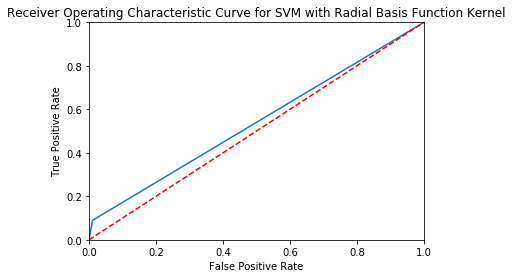


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Loss ----------

0.23194289207458496 seconds for  Neural Network with ReLU activation  to train
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7580784438485662
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7664061079803672

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4088         51
True >50k       1234        128

F1-score is: 0.16612589227774174


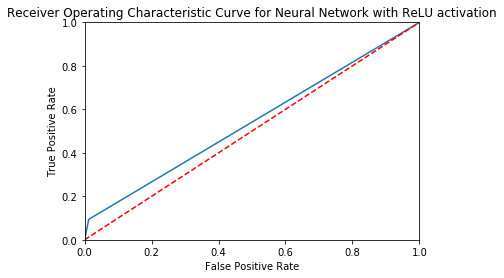


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Loss ----------

0.2794229984283447 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7585329273280916
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7667696782403199

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4090         49
True >50k       1234        128

F1-score is: 0.1663417803768681


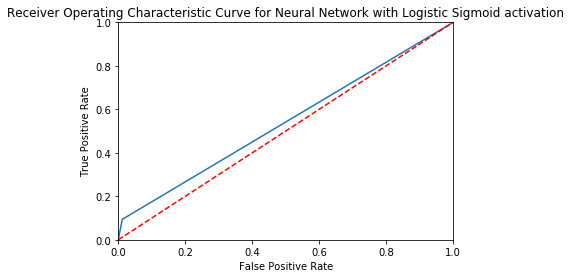


---------- Results Summary for Neural Network with tanh activation for the column: Capital Loss ----------

0.42067623138427734 seconds for  Neural Network with tanh activation  to train
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7585329273280916
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7667696782403199

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4090         49
True >50k       1234        128

F1-score is: 0.1663417803768681


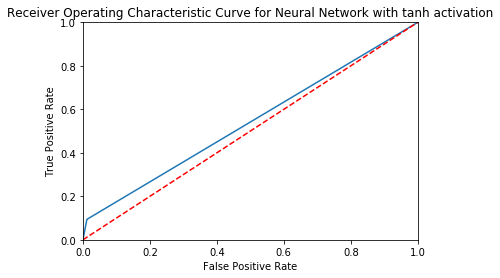


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Loss ----------

0.002557992935180664 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.743989455983275
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


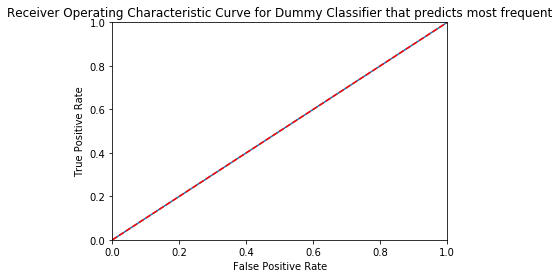


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Capital Loss ----------

0.0018372535705566406 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Capital Loss as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6253238194791619
Using Capital Loss as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3092       1047
True >50k       1008        354

F1-score is: 0.2557142857142857


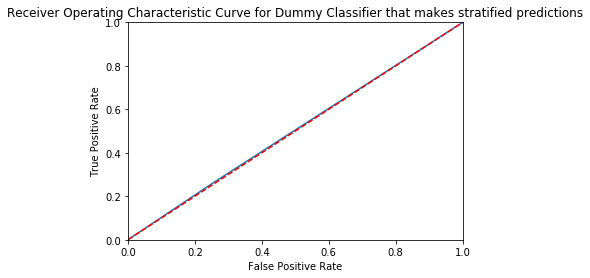


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Capital Loss ----------

0.0016679763793945312 seconds for  Dummy Classifier that maximizes the prior  to train
Using Capital Loss as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.743989455983275
Using Capital Loss as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


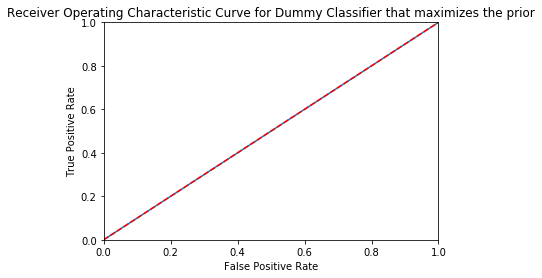


--------------- Returning Algorithm Results Summary for the feature: Hours Per Week ---------------

---------- Results Summary for GaussianNB for the column: Hours Per Week ----------

0.002628803253173828 seconds for  GaussianNB  to train
Using Hours Per Week as a predictor for  GaussianNB  we get train accuracy of:  0.743989455983275
Using Hours Per Week as a predictor for  GaussianNB  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


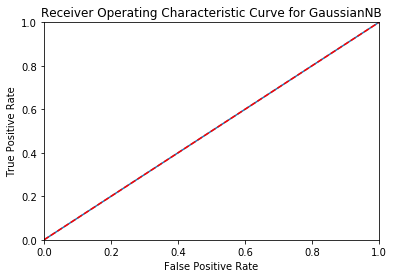


---------- Results Summary for SVM with Linear Kernel for the column: Hours Per Week ----------

6.137015104293823 seconds for  SVM with Linear Kernel  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.743989455983275
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


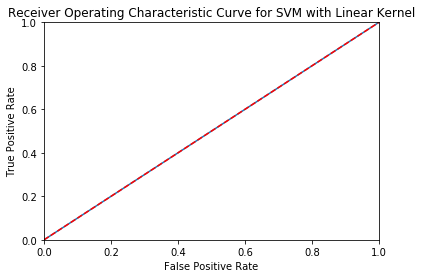


---------- Results Summary for SVM with Sigmoid Kernel for the column: Hours Per Week ----------

6.3280181884765625 seconds for  SVM with Sigmoid Kernel  to train
Using Hours Per Week as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.6701813389083306
Using Hours Per Week as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.6830154405086285

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3260        879
True >50k        946        416

F1-score is: 0.3131351147911178


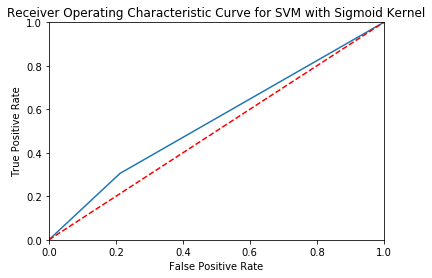


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Hours Per Week ----------

6.889891147613525 seconds for  SVM with Radial Basis Function Kernel  to train
Using Hours Per Week as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.743989455983275
Using Hours Per Week as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


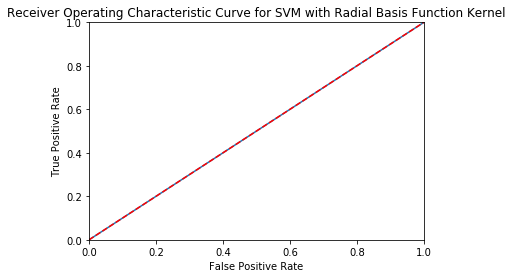


---------- Results Summary for Neural Network with ReLU activation for the column: Hours Per Week ----------

0.5267317295074463 seconds for  Neural Network with ReLU activation  to train
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.743989455983275
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


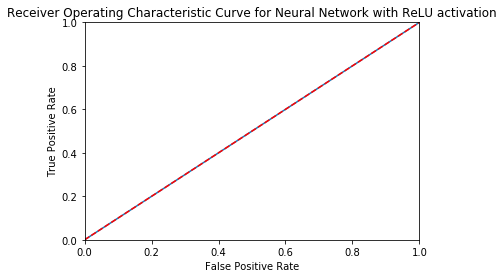


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Hours Per Week ----------

0.19066905975341797 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.743989455983275
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


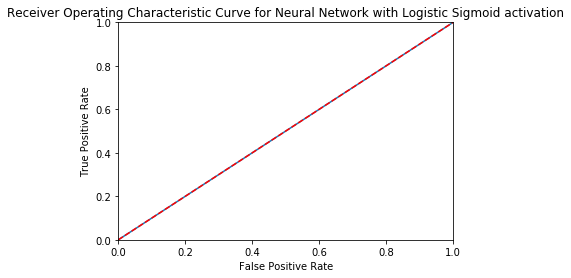


---------- Results Summary for Neural Network with tanh activation for the column: Hours Per Week ----------

0.23270201683044434 seconds for  Neural Network with tanh activation  to train
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.743989455983275
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


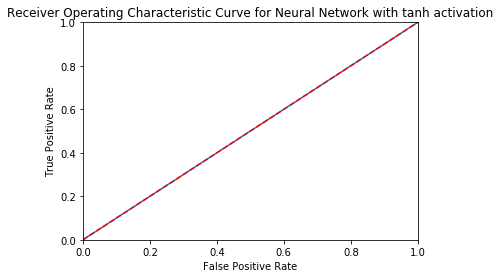


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Hours Per Week ----------

0.0022039413452148438 seconds for  Dummy Classifier that predicts most frequent  to train
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.743989455983275
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


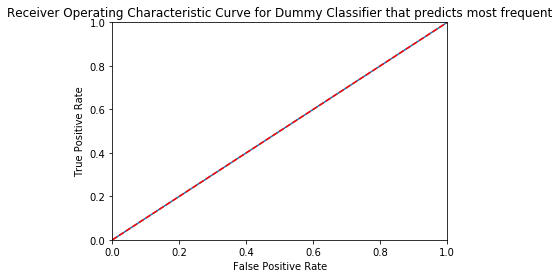


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Hours Per Week ----------

0.0030121803283691406 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Hours Per Week as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6150524928418852
Using Hours Per Week as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3121       1018
True >50k       1005        357

F1-score is: 0.24810674359899026


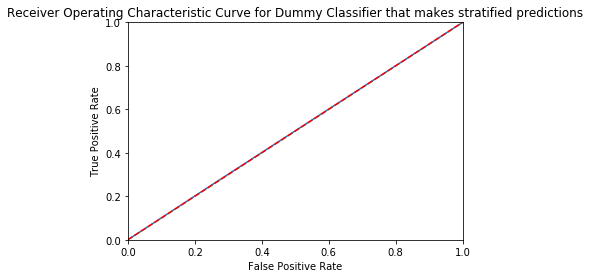


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Hours Per Week ----------

0.0023550987243652344 seconds for  Dummy Classifier that maximizes the prior  to train
Using Hours Per Week as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.743989455983275
Using Hours Per Week as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


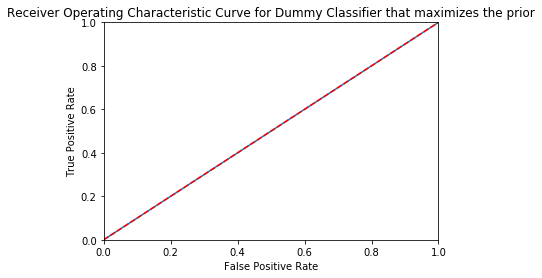


--------------- Returning Algorithm Results Summary for the feature: Workclass ---------------

---------- Results Summary for GaussianNB for the column: Workclass ----------

0.0060901641845703125 seconds for  GaussianNB  to train
Using Workclass as a predictor for  GaussianNB  we get train accuracy of:  0.2564650274962505
Using Workclass as a predictor for  GaussianNB  we get test accuracy of:  0.24813670241774222

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k          3       4136
True >50k          0       1362

F1-score is: 0.39708454810495625


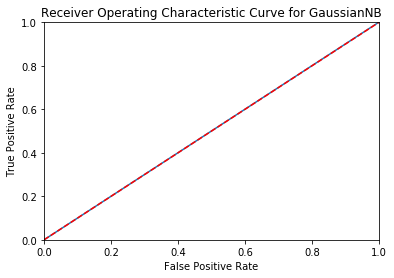


---------- Results Summary for SVM with Linear Kernel for the column: Workclass ----------

4.218548059463501 seconds for  SVM with Linear Kernel  to train
Using Workclass as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7491705676498659
Using Workclass as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7602179836512262

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4060         79
True >50k       1272         90

F1-score is: 0.11757021554539518


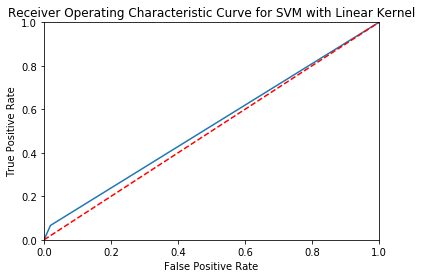


---------- Results Summary for SVM with Sigmoid Kernel for the column: Workclass ----------

7.655957937240601 seconds for  SVM with Sigmoid Kernel  to train
Using Workclass as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7491705676498659
Using Workclass as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7602179836512262

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4060         79
True >50k       1272         90

F1-score is: 0.11757021554539518


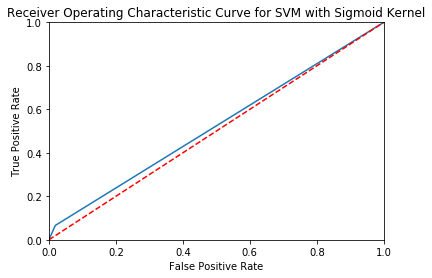


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Workclass ----------

6.86933708190918 seconds for  SVM with Radial Basis Function Kernel  to train
Using Workclass as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7491705676498659
Using Workclass as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7602179836512262

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4060         79
True >50k       1272         90

F1-score is: 0.11757021554539518


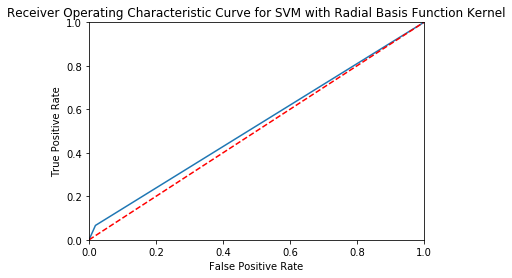


---------- Results Summary for Neural Network with ReLU activation for the column: Workclass ----------

0.3588449954986572 seconds for  Neural Network with ReLU activation  to train
Using Workclass as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7491705676498659
Using Workclass as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.754408289401927

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4060         79
True >50k       1272         90

F1-score is: 0.11757021554539518


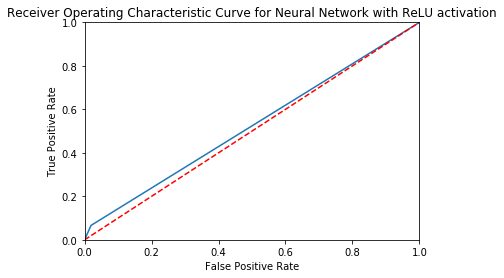


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Workclass ----------

0.2609138488769531 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7491705676498659
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.754408289401927

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4060         79
True >50k       1272         90

F1-score is: 0.11757021554539518


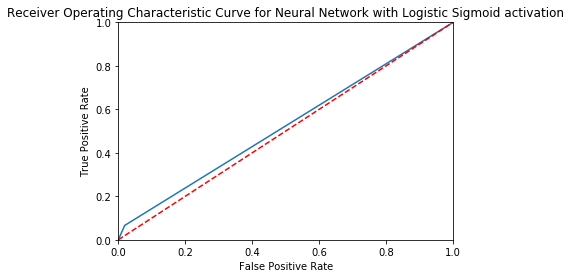


---------- Results Summary for Neural Network with tanh activation for the column: Workclass ----------

0.16893291473388672 seconds for  Neural Network with tanh activation  to train
Using Workclass as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7491705676498659
Using Workclass as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.754408289401927

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4060         79
True >50k       1272         90

F1-score is: 0.11757021554539518


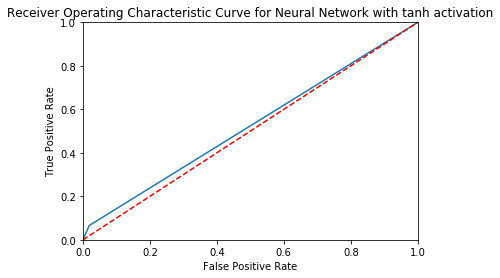


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Workclass ----------

0.0027472972869873047 seconds for  Dummy Classifier that predicts most frequent  to train
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.743989455983275
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


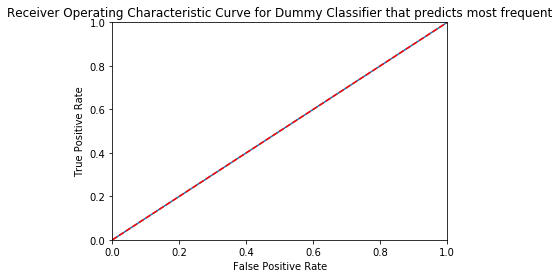


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Workclass ----------

0.0029897689819335938 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Workclass as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6208244330318593
Using Workclass as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3119       1020
True >50k       1005        357

F1-score is: 0.2652482269503546


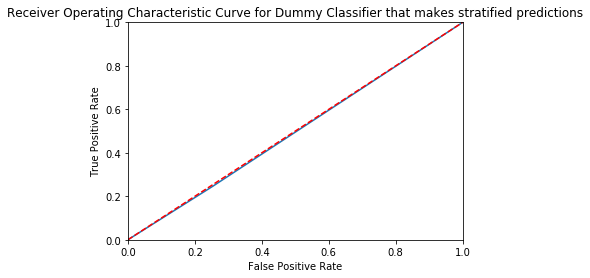


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Workclass ----------

0.002104043960571289 seconds for  Dummy Classifier that maximizes the prior  to train
Using Workclass as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.743989455983275
Using Workclass as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


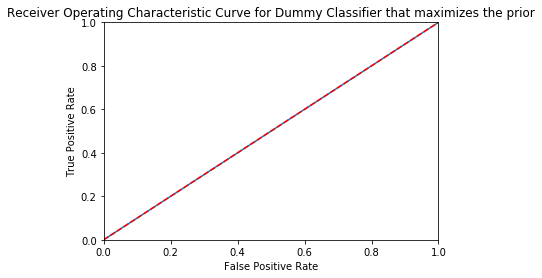


--------------- Returning Algorithm Results Summary for the feature: Marital Status ---------------

---------- Results Summary for GaussianNB for the column: Marital Status ----------

0.006147861480712891 seconds for  GaussianNB  to train
Using Marital Status as a predictor for  GaussianNB  we get train accuracy of:  0.7121301640685361
Using Marital Status as a predictor for  GaussianNB  we get test accuracy of:  0.7196873295764407

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2792       1347
True >50k        195       1167

F1-score is: 0.6021671826625387


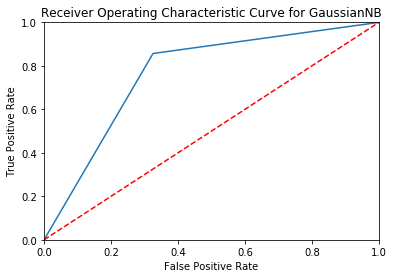


---------- Results Summary for SVM with Linear Kernel for the column: Marital Status ----------

4.83325982093811 seconds for  SVM with Linear Kernel  to train
Using Marital Status as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.743989455983275
Using Marital Status as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


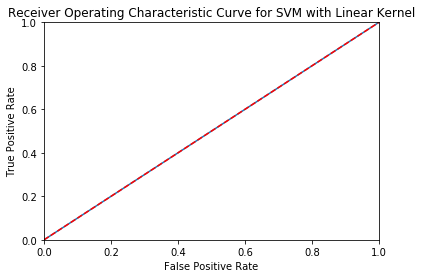


---------- Results Summary for SVM with Sigmoid Kernel for the column: Marital Status ----------

8.371482849121094 seconds for  SVM with Sigmoid Kernel  to train
Using Marital Status as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.743989455983275
Using Marital Status as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


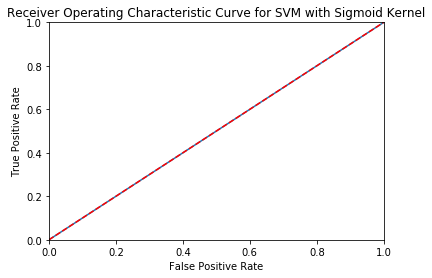


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Marital Status ----------

7.70578408241272 seconds for  SVM with Radial Basis Function Kernel  to train
Using Marital Status as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.743989455983275
Using Marital Status as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


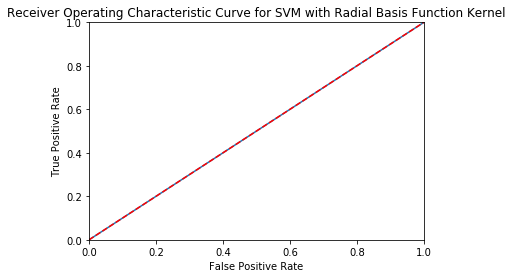


---------- Results Summary for Neural Network with ReLU activation for the column: Marital Status ----------

0.3041112422943115 seconds for  Neural Network with ReLU activation  to train
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.743989455983275
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


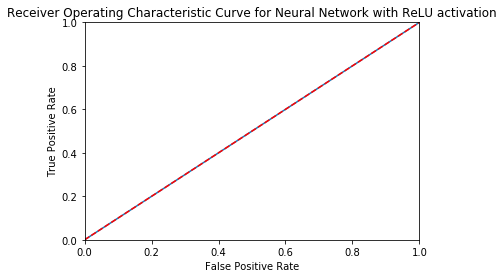


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Marital Status ----------

0.255403995513916 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.743989455983275
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


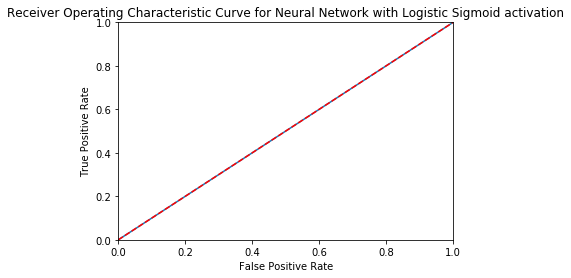


---------- Results Summary for Neural Network with tanh activation for the column: Marital Status ----------

0.2723393440246582 seconds for  Neural Network with tanh activation  to train
Using Marital Status as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.743989455983275
Using Marital Status as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


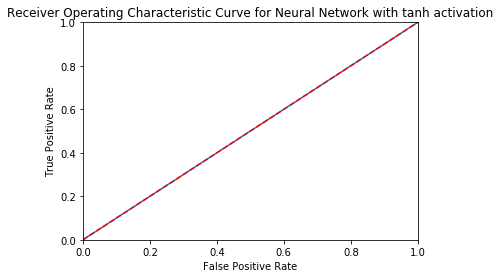


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Marital Status ----------

0.0018949508666992188 seconds for  Dummy Classifier that predicts most frequent  to train
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.743989455983275
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


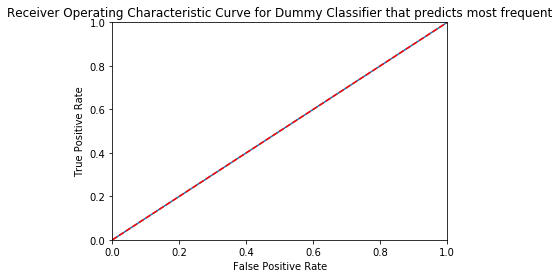


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Marital Status ----------

0.0018849372863769531 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Marital Status as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6240512657364905
Using Marital Status as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3085       1054
True >50k       1007        355

F1-score is: 0.25411937019406816


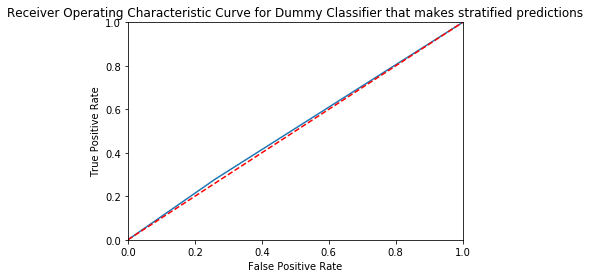


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Marital Status ----------

0.0017728805541992188 seconds for  Dummy Classifier that maximizes the prior  to train
Using Marital Status as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.743989455983275
Using Marital Status as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


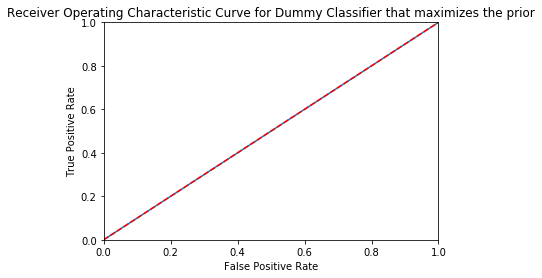


--------------- Returning Algorithm Results Summary for the feature: Occupation ---------------

---------- Results Summary for GaussianNB for the column: Occupation ----------

0.007928133010864258 seconds for  GaussianNB  to train
Using Occupation as a predictor for  GaussianNB  we get train accuracy of:  0.5840112711902923
Using Occupation as a predictor for  GaussianNB  we get test accuracy of:  0.5740774404653699

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2073       2066
True >50k        277       1085

F1-score is: 0.48083314868158655


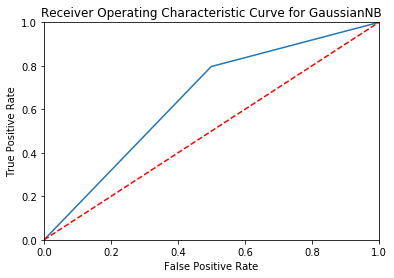


---------- Results Summary for SVM with Linear Kernel for the column: Occupation ----------

7.239589691162109 seconds for  SVM with Linear Kernel  to train
Using Occupation as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.743989455983275
Using Occupation as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


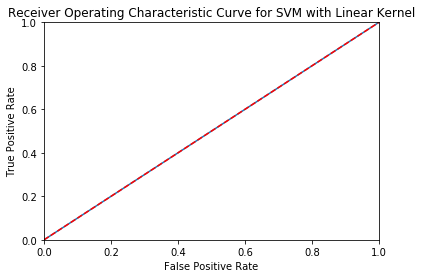


---------- Results Summary for SVM with Sigmoid Kernel for the column: Occupation ----------

8.82401990890503 seconds for  SVM with Sigmoid Kernel  to train
Using Occupation as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.743989455983275
Using Occupation as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


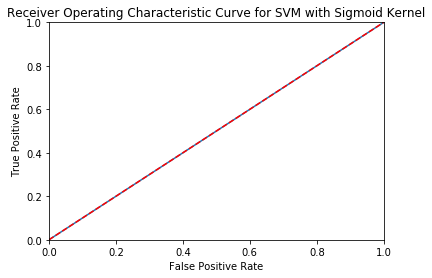


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Occupation ----------

10.806492328643799 seconds for  SVM with Radial Basis Function Kernel  to train
Using Occupation as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.743989455983275
Using Occupation as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


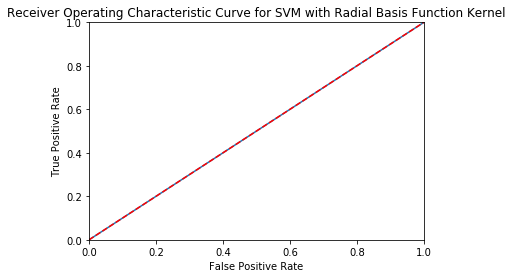


---------- Results Summary for Neural Network with ReLU activation for the column: Occupation ----------

0.7324233055114746 seconds for  Neural Network with ReLU activation  to train
Using Occupation as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.743989455983275
Using Occupation as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


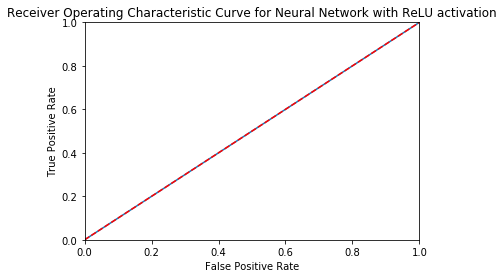


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Occupation ----------

0.3305699825286865 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.743989455983275
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


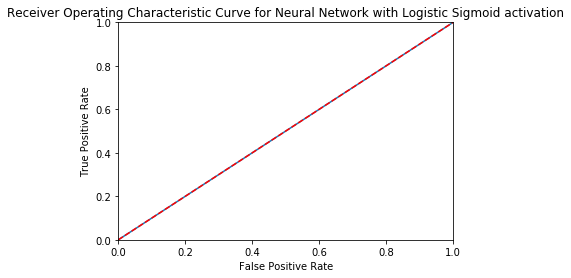


---------- Results Summary for Neural Network with tanh activation for the column: Occupation ----------

0.5329170227050781 seconds for  Neural Network with tanh activation  to train
Using Occupation as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.743989455983275
Using Occupation as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


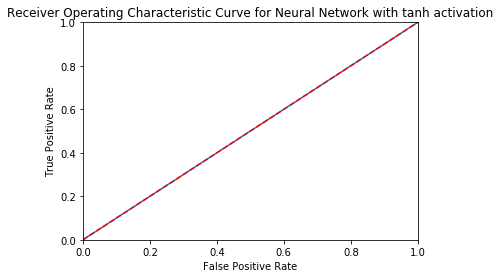


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Occupation ----------

0.003183126449584961 seconds for  Dummy Classifier that predicts most frequent  to train
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.743989455983275
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


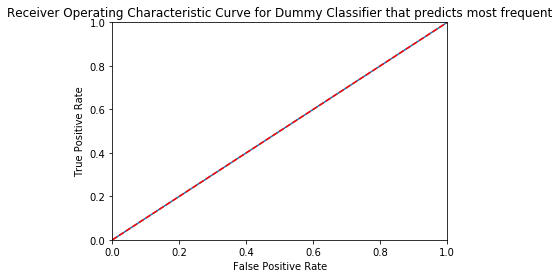


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Occupation ----------

0.0021359920501708984 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Occupation as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6190519474617098
Using Occupation as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3057       1082
True >50k       1012        350

F1-score is: 0.2617763394462424


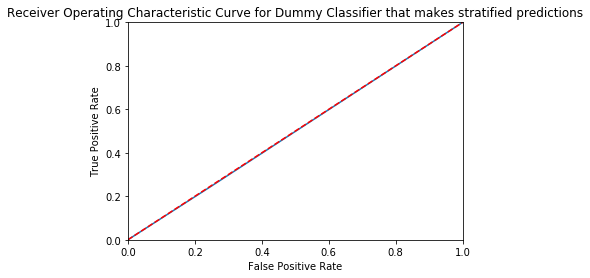


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Occupation ----------

0.0020580291748046875 seconds for  Dummy Classifier that maximizes the prior  to train
Using Occupation as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.743989455983275
Using Occupation as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


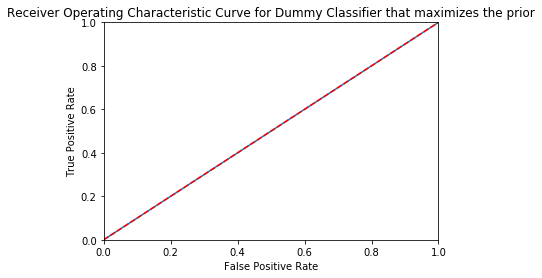


--------------- Returning Algorithm Results Summary for the feature: Relationship ---------------

---------- Results Summary for GaussianNB for the column: Relationship ----------

0.0045778751373291016 seconds for  GaussianNB  to train
Using Relationship as a predictor for  GaussianNB  we get train accuracy of:  0.7156751352088352
Using Relationship as a predictor for  GaussianNB  we get test accuracy of:  0.7227776767860389

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2812       1327
True >50k        198       1164

F1-score is: 0.6042045159615884


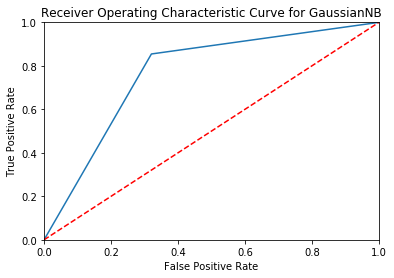


---------- Results Summary for SVM with Linear Kernel for the column: Relationship ----------

4.611321210861206 seconds for  SVM with Linear Kernel  to train
Using Relationship as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7447620778984684
Using Relationship as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4015        124
True >50k       1236        126

F1-score is: 0.1563275434243176


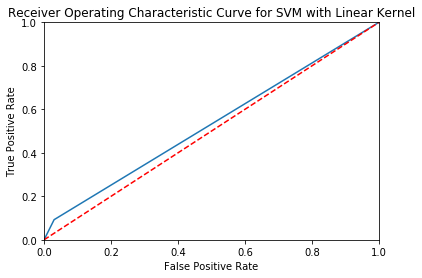


---------- Results Summary for SVM with Sigmoid Kernel for the column: Relationship ----------

8.001114130020142 seconds for  SVM with Sigmoid Kernel  to train
Using Relationship as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7447620778984684
Using Relationship as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4015        124
True >50k       1236        126

F1-score is: 0.1563275434243176


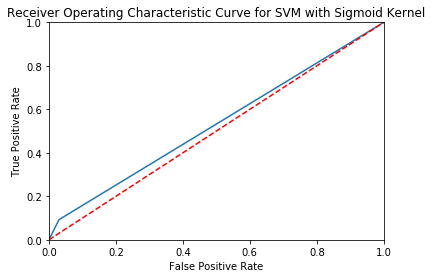


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Relationship ----------

7.813945770263672 seconds for  SVM with Radial Basis Function Kernel  to train
Using Relationship as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7447620778984684
Using Relationship as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4015        124
True >50k       1236        126

F1-score is: 0.1563275434243176


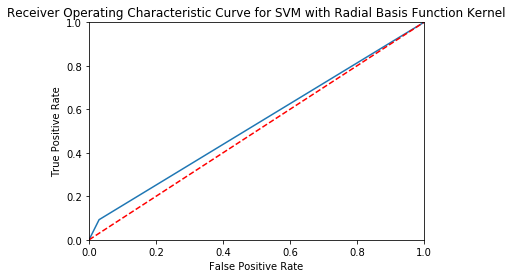


---------- Results Summary for Neural Network with ReLU activation for the column: Relationship ----------

0.29190516471862793 seconds for  Neural Network with ReLU activation  to train
Using Relationship as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.743989455983275
Using Relationship as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


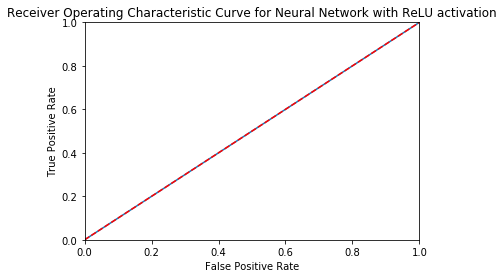


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Relationship ----------

0.2945680618286133 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.743989455983275
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


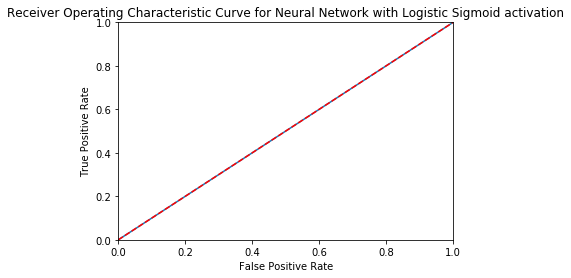


---------- Results Summary for Neural Network with tanh activation for the column: Relationship ----------

0.3875110149383545 seconds for  Neural Network with tanh activation  to train
Using Relationship as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7447620778984684
Using Relationship as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7527722232321397

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4015        124
True >50k       1236        126

F1-score is: 0.1563275434243176


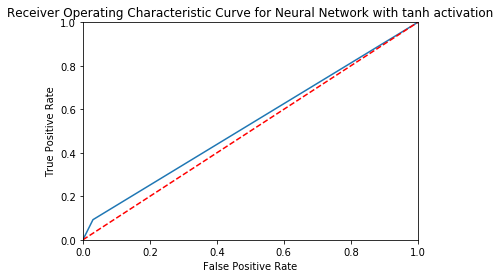


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Relationship ----------

0.0019807815551757812 seconds for  Dummy Classifier that predicts most frequent  to train
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.743989455983275
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


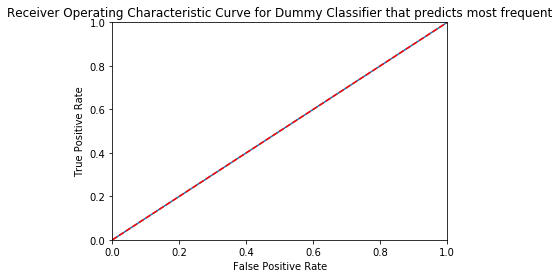


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Relationship ----------

0.0018849372863769531 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Relationship as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6194609825932827
Using Relationship as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3019       1120
True >50k       1010        352

F1-score is: 0.24264438794042864


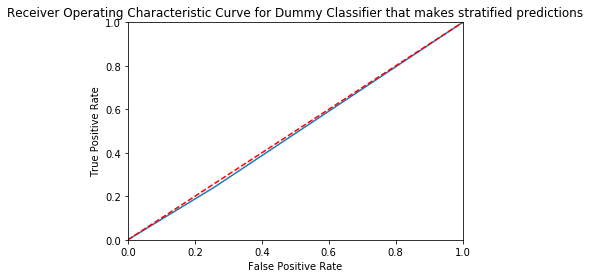


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Relationship ----------

0.0017559528350830078 seconds for  Dummy Classifier that maximizes the prior  to train
Using Relationship as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.743989455983275
Using Relationship as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


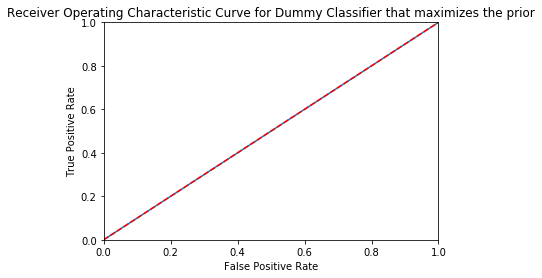


--------------- Returning Algorithm Results Summary for the feature: Race ---------------

---------- Results Summary for GaussianNB for the column: Race ----------

0.00694584846496582 seconds for  GaussianNB  to train
Using Race as a predictor for  GaussianNB  we get train accuracy of:  0.34254419851838386
Using Race as a predictor for  GaussianNB  we get test accuracy of:  0.33303035811670606

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k        558       3581
True >50k         88       1274

F1-score is: 0.4098439761943059


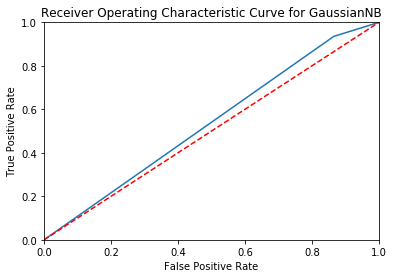


---------- Results Summary for SVM with Linear Kernel for the column: Race ----------

3.307752847671509 seconds for  SVM with Linear Kernel  to train
Using Race as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.743989455983275
Using Race as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


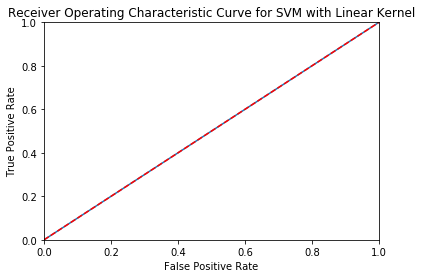


---------- Results Summary for SVM with Sigmoid Kernel for the column: Race ----------

5.550711154937744 seconds for  SVM with Sigmoid Kernel  to train
Using Race as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.743989455983275
Using Race as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


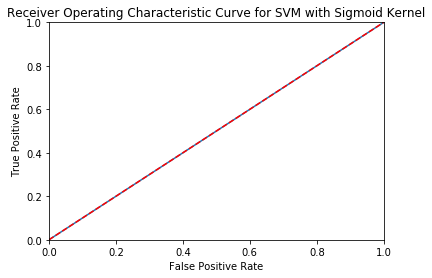


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Race ----------

4.911947011947632 seconds for  SVM with Radial Basis Function Kernel  to train
Using Race as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.743989455983275
Using Race as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7527272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


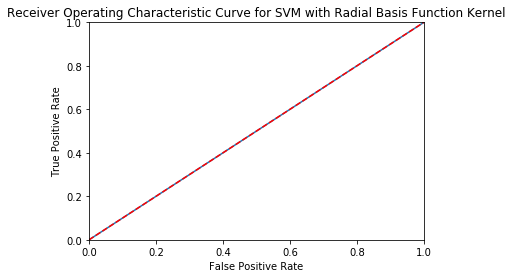


---------- Results Summary for Neural Network with ReLU activation for the column: Race ----------

0.13725805282592773 seconds for  Neural Network with ReLU activation  to train
Using Race as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.743989455983275
Using Race as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


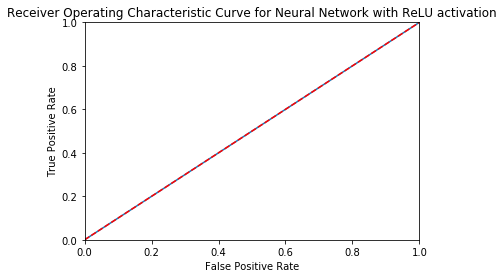


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Race ----------

0.2076740264892578 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.743989455983275
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


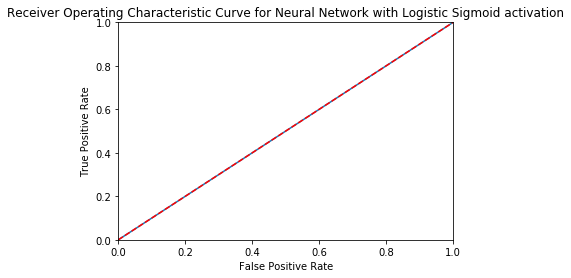


---------- Results Summary for Neural Network with tanh activation for the column: Race ----------

0.20261096954345703 seconds for  Neural Network with tanh activation  to train
Using Race as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.743989455983275
Using Race as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7524086529721868

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


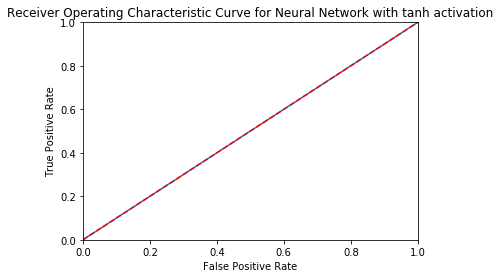


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Race ----------

0.004378795623779297 seconds for  Dummy Classifier that predicts most frequent  to train
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.743989455983275
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


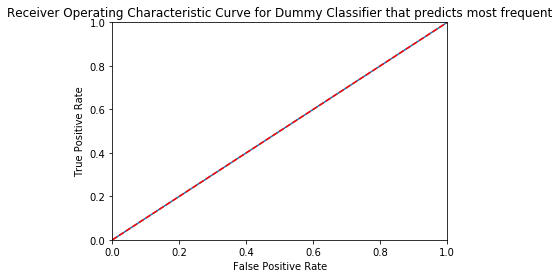


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Race ----------

0.0018661022186279297 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Race as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.622278780166341
Using Race as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3044       1095
True >50k       1020        342

F1-score is: 0.23267687819110136


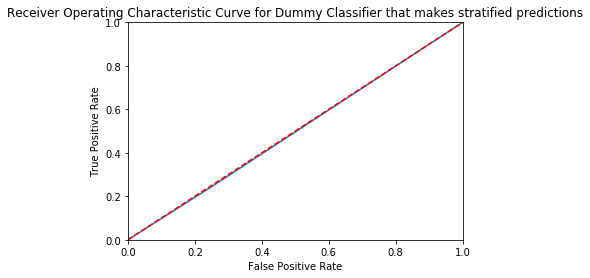


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Race ----------

0.001683950424194336 seconds for  Dummy Classifier that maximizes the prior  to train
Using Race as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.743989455983275
Using Race as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


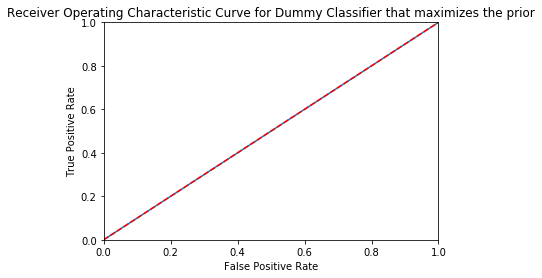


--------------- Returning Algorithm Results Summary for the feature: All Columns ---------------

---------- Results Summary for GaussianNB for the column: All Columns ----------

0.019863605499267578 seconds for  GaussianNB  to train
Using All Columns as a predictor for  GaussianNB  we get train accuracy of:  0.6553197291278462
Using All Columns as a predictor for  GaussianNB  we get test accuracy of:  0.640792583166697

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2262       1877
True >50k         99       1263

F1-score is: 0.5610839626832519


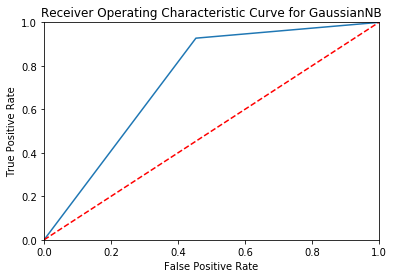


---------- Results Summary for SVM with Linear Kernel for the column: All Columns ----------

26.845386028289795 seconds for  SVM with Linear Kernel  to train
Using All Columns as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.8458392037449439
Using All Columns as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.8581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3847        292
True >50k        551        811

F1-score is: 0.6580121703853955


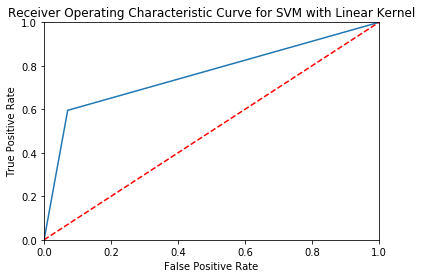


---------- Results Summary for SVM with Sigmoid Kernel for the column: All Columns ----------

26.07607913017273 seconds for  SVM with Sigmoid Kernel  to train
Using All Columns as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7775757851202109
Using All Columns as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.8363636363636363

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3566        573
True >50k        636        726

F1-score is: 0.5456595264937993


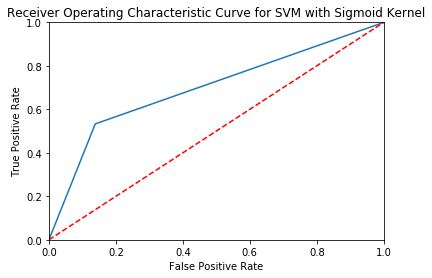


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: All Columns ----------

20.78250789642334 seconds for  SVM with Radial Basis Function Kernel  to train
Using All Columns as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.8547016315956915
Using All Columns as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.8563636363636363

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3876        263
True >50k        578        784

F1-score is: 0.650892486508925


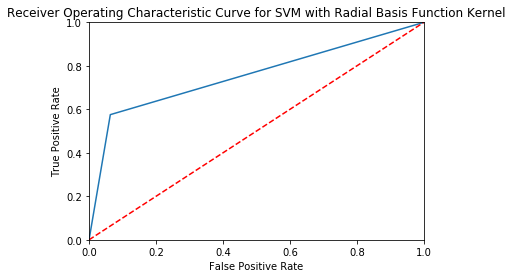


---------- Results Summary for Neural Network with ReLU activation for the column: All Columns ----------

1.8004570007324219 seconds for  Neural Network with ReLU activation  to train
Using All Columns as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.8543834931600236
Using All Columns as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.8547536811488821

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3837        302
True >50k        497        865

F1-score is: 0.6840648477659154


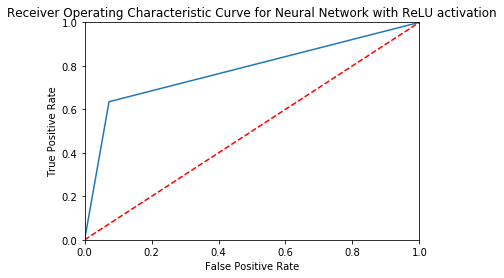


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: All Columns ----------

1.0852909088134766 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.8533381811571149
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.8531176149790947

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3843        296
True >50k        512        850

F1-score is: 0.6778309409888358


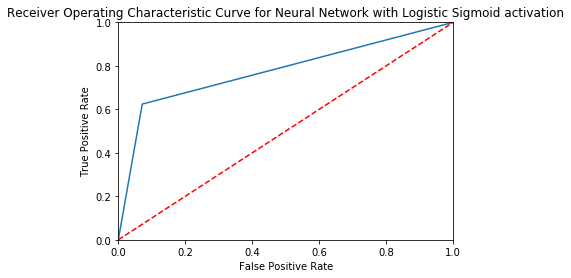


---------- Results Summary for Neural Network with tanh activation for the column: All Columns ----------

1.7712016105651855 seconds for  Neural Network with tanh activation  to train
Using All Columns as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.8562014270781257
Using All Columns as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.8542083257589529

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3848        291
True >50k        511        851

F1-score is: 0.6797124600638977


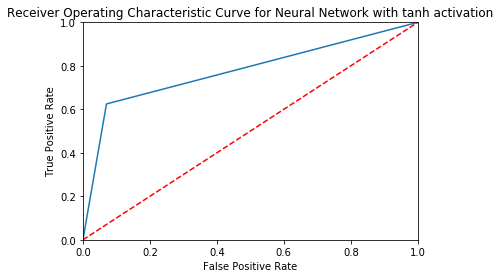


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: All Columns ----------

0.002853870391845703 seconds for  Dummy Classifier that predicts most frequent  to train
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.743989455983275
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


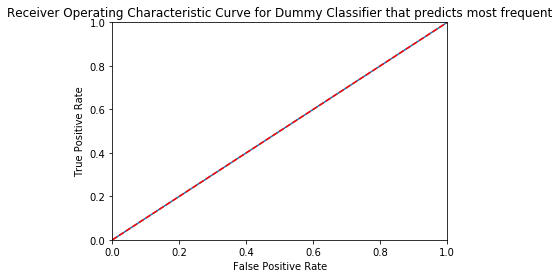


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: All Columns ----------

0.0027577877044677734 seconds for  Dummy Classifier that makes stratified predictions  to train
Using All Columns as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6194155342453301
Using All Columns as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3097       1042
True >50k        974        388

F1-score is: 0.2514492753623188


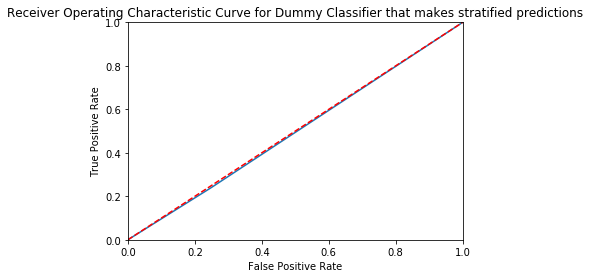


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: All Columns ----------

0.0026769638061523438 seconds for  Dummy Classifier that maximizes the prior  to train
Using All Columns as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.743989455983275
Using All Columns as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4139          0
True >50k       1362          0

F1-score is: 0.0


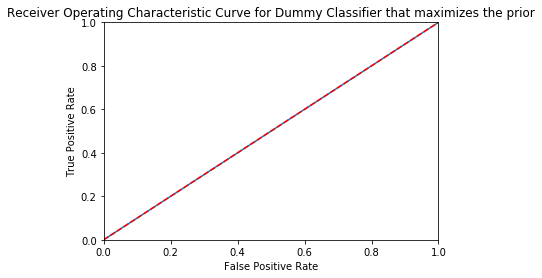

In [20]:
Y = np.array(new_df.iloc[:,46:47]) #labels
num_training = int(0.8*Y.shape[0])  #80% of the data for training
sc = StandardScaler()

for i in range(len(ranges)):
    print('--------------- Returning Algorithm Results Summary for the feature:',columns[i],'---------------')
    print()
    for j in range(len(classifiers)):
        if j == 1 or j == 2 or j == 3:   # if it is svm do cross validation
            return_results(classifiers[j],names[j],True,False,i)
        elif j == 7 or j == 8 or j ==9:  # if it is a dummyclassifier, calculate accuracy the proper way
            return_results(classifiers[j],names[j],False,True,i)  
        else:    # if a regular classifier, just do the normal operations
            return_results(classifiers[j],names[j],False,False,i)